# <center>Итоговый проект: Классификация обращений пациентов</center>

Для задания нам был дан датасет, содержащий русскоязычный набор данных из 3941 разговоров пациентов с медицинским ботом в режиме QA. 
* **Обучающая выборка** включает 3546 разговоров; 
* **Тестовая выборка** включает 395 разговоров.

**<u>Характеристики признаков:</u>** 

* `'topic'` - медицинская тема 
* `'user_question'` - последний вопрос пользователя 
* `'assistant_answer'` - ответ AI в соответствии с контекстом и темой 
* `'to_doctor'` - специальность врача, к которому помощник направил пациента 
* `'__index_level_0__'` - пояснений к этому признаку, к сожалению, не было
* `'prompt'` - готовая подсказка (адаптирована для использования при помощи [unsloth](https://github.com/unslothai/unsloth?tab=readme-ov-file))

## <center>1. Предобработка данных и анализ данных (EDA)</center>

In [259]:
# Уберем предупреждения, чтобы они не загромождали вывод
import warnings
warnings.filterwarnings('ignore')

In [319]:
# Импорт необходимых библиотек:
import pandas as pd                                 # Для работы с табличными данными
import re                                           # Импорт модуля для работы с регулярными выражениями
import seaborn as sns                               # Импорт библиотеки seaborn для создания визуализаций данных
import numpy as np                                  # Импорт библиотеки numpy для работы с массивами и числовыми операциями
import nltk                                         # Для использования библиотеки Natural Language Toolkit (NLTK)
import torch                                        # Для работы с нейронными сетями
import sklearn.metrics                              # Импорт модуля для работы с метриками оценки моделей

from nltk.tokenize import word_tokenize             # Импорт функции, которая делит текст на токены
from nltk.util import ngrams                        # Позволяет генерировать n-граммы
from matplotlib import pyplot as plt                # Импорт функции pyplot из библиотеки matplotlib для создания графиков и визуализаций
from collections import Counter                     # Используется для подсчёта объектов
from wordcloud import WordCloud                     # Для создания облака слов
from gensim.models import Word2Vec                  # Преобразует слова в векторы определённой размерности, где схожие по смыслу слова имеют близкие векторные представления
from sklearn.linear_model import LogisticRegression # Импорт модели логистической регрессии
from sklearn.tree import DecisionTreeClassifier     # Импорт модели дерева решений
from sklearn.ensemble import RandomForestClassifier # Импорт модели случайного леса
from sklearn.model_selection import GridSearchCV    # Импорт модели решётчатого поиска гиперпараметров
from sklearn.metrics import confusion_matrix        # Импорт функции для создания матрицы ошибок
from transformers import AutoTokenizer, AutoModel   # Для упрощения процесса выбора правильного токенизатора и претренированных моделей

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [261]:
# Знакомство с данными
new_data = pd.read_parquet('data/train.parquet')
new_data

,topic,user_question,assistant_answer,to_doctor,__index_level_0__,prompt
0,лабораторные исследования,Я сдала анализ крови на сахар и показатели чут...,Повышение уровня сахара в крови может быть выз...,эндокринолог,3263,<s><|user|>Я сдала анализ крови на сахар и пок...
1,педиатрия,"Мой ребенок кашляет уже 3 дня, отхаркивается с...",Кашель у детей может быть вызван разными причи...,педиатр,518,"<s><|user|>Мой ребенок кашляет уже 3 дня, отха..."
2,проктология,Я заметил не очень приятного вида опухоль возл...,"Извините, я не могу ставить диагнозы. Анальные...",проктолог,1160,<s><|user|>Я заметил не очень приятного вида о...
3,эндокринология,У меня повышенный уровень сахара в крови. Врач...,Повышенный уровень сахара в крови - это действ...,эндокринолог,286,<s><|user|>У меня повышенный уровень сахара в ...
4,семейная медицина,У меня постоянно болит голова. Я уже несколько...,Головные боли могут быть вызваны множеством пр...,невролог,2132,<s><|user|>У меня постоянно болит голова. Я уж...
...,...,...,...,...,...,...
3541,хирургия,вопрос user по его конкретной медицинской проб...,твой конкретный ответ не длиннее 5-15 предложе...,нутрициология,3723,<s><|user|>вопрос user по его конкретной медиц...
3542,травматология,"У меня ушиб локтя, очень болит и опух. Что дел...","Ушиб локтя - это распространенная травма, кото...",травматолог,2586,"<s><|user|>У меня ушиб локтя, очень болит и оп..."
3543,хирургия,"У меня болит живот, врач предположил, что это ...",Боль в животе может быть вызвана множеством пр...,хирург,610,"<s><|user|>У меня болит живот, врач предположи..."
3544,психиатрия,"Я чувствую постоянную тревогу и усталость, даж...",Постоянная тревога и усталость могут быть приз...,психиатр,2200,<s><|user|>Я чувствую постоянную тревогу и уст...


In [262]:
# Посмотрим информацию о признаках
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3546 entries, 0 to 3545
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   topic              3546 non-null   object
 1   user_question      3546 non-null   object
 2   assistant_answer   3546 non-null   object
 3   to_doctor          3546 non-null   object
 4   __index_level_0__  3546 non-null   int64 
 5   prompt             3546 non-null   object
dtypes: int64(1), object(5)
memory usage: 166.3+ KB


In [263]:
# Подсчитаем кол-во уникальных значений внутри каждого признака
for col in new_data.columns:
    print(f'Признак: {new_data[col].value_counts(dropna=False)}')
    print('-' * 60)

Признак: topic
кардиология                  188
андрология                   176
проктология                  168
лабораторные исследования    163
неврология                   163
хирургия                     159
травматология                158
психиатрия                   158
дерматология                 156
стоматология                 156
эндокринология               155
онкология                    154
аллергология                 153
репродуктология              150
нутрициология                150
педиатрия                    147
косметология                 147
диетология                   147
семейная медицина            145
гинекология                  143
офтальмология                131
урология                     126
терапия                       96
терапевт                      21
Семейная медицина             11
Кардиология                    4
нейрология                     4
Онкология                      3
Нутрициология                  2
Терапия                     

**<u>Предварительные выводы по признакам:</u>**

1) `'topic'`

    * Кол-во топиков очень большое. Потенциально их можно объединить, тем самым уменьшив кол-во. Особенно бросаются в глаза такие топики как "терапия сахарного диабета". Уж больно узкий профиль, имеет смысл добавить такой топик либо в терапевтический профиль, либо в эндокринологический, если такой будет.

    * Также имеет место написание одного и того же профиля в разных вариациях: "терапи", "терапия", "Терапия", "terapia" и т.д.

2) `'user_question'`

    * Необходимо будет привести тексты к единому формату: удалить спецсимволы, числа и привести буквы к нижнему регистру. 

3) `'assistant_answer'`

    * Необходимо будет привести тексты к единому формату: удалить спецсимволы, числа и привести буквы к нижнему регистру. 

4) `'to_doctor'`

    * Специальности так или иначе пересекаются с топиками. Возможно имеет смысл оставить какой-то один признак, т.к. корреляция у них будет большая, да и для модели два признака с идентичной информацией не нужны.
    * Общение №3541, отобразившееся в хвосте датасета, показывает, что данные стоит внимательнее изучить, т.к. топик обращения "хирургия", а юзер был направлен к врачу "нутрициология". И тут непонятно, на что ориентироваться, что точнее описывает профиль обращения - топики или специальность врача, к которому был направлен юзер ботом.

5) `'__index_level_0__'`

    * Пояснений к данному признаку не было никаких. Вначале подумал, может быть это кодировка специальностей докторов, но оказалось, что все значения уникальные. Имеет смысл удалить данный признак.

6) `'prompt'` 

Для нашей задачи нам по факту необходимо 2 признака: вопрос и специальность врача. Если с первым всё понятно, то со вторым надо определиться, либо брать её из `'topic'`, либо из `'to_doctor'`.

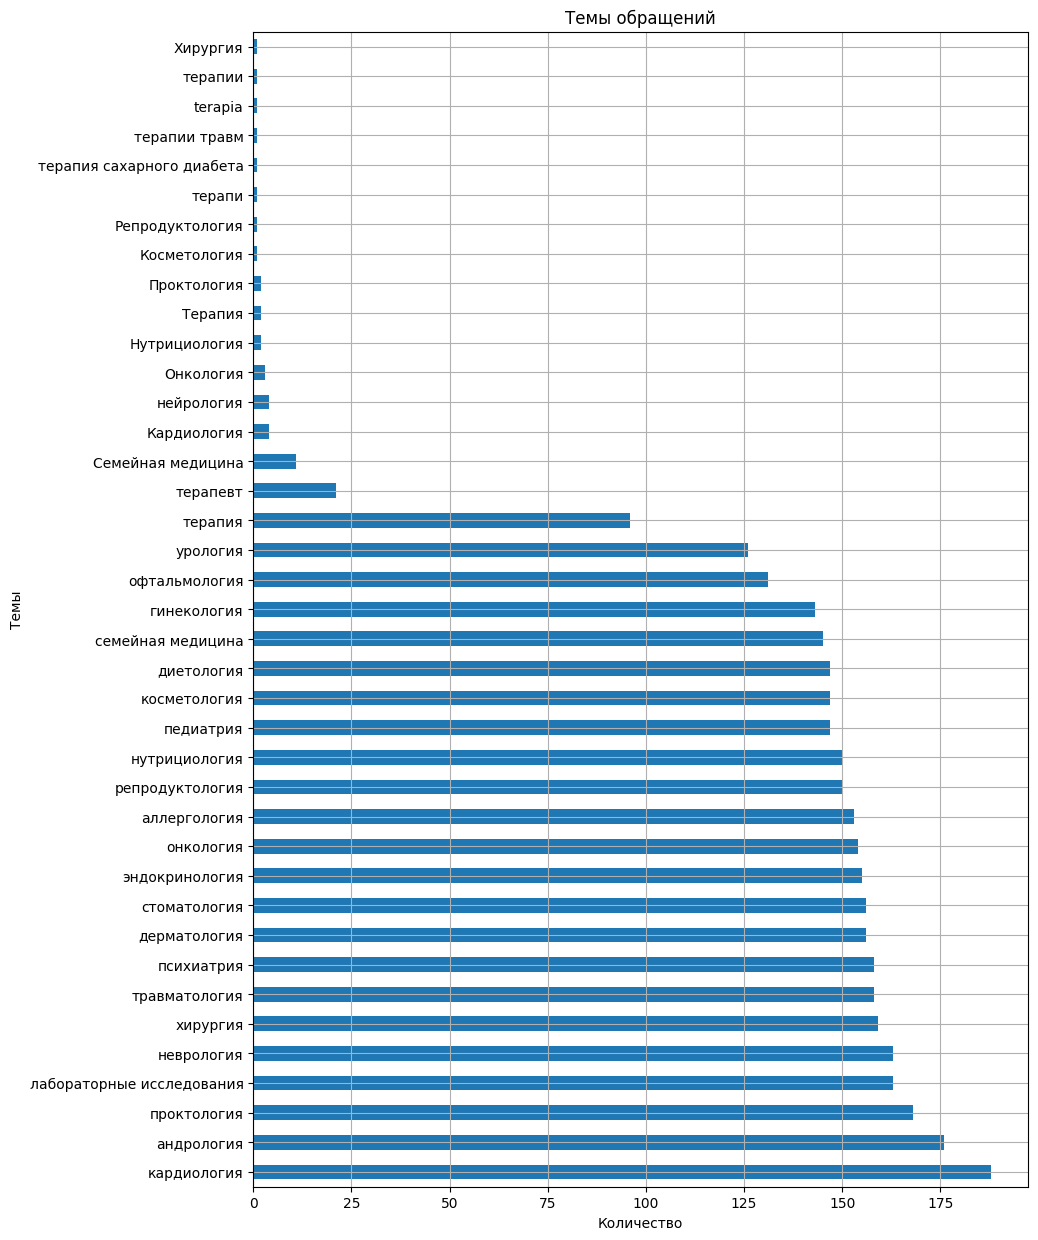

In [264]:
# Посмотрим какие топики у нас есть и в каком кол-ве
plt.figure(figsize=(10, 15))
new_data['topic'].value_counts().plot(kind='barh')
plt.title('Темы обращений')
plt.xlabel('Количество')
plt.ylabel('Темы')
plt.grid(True)

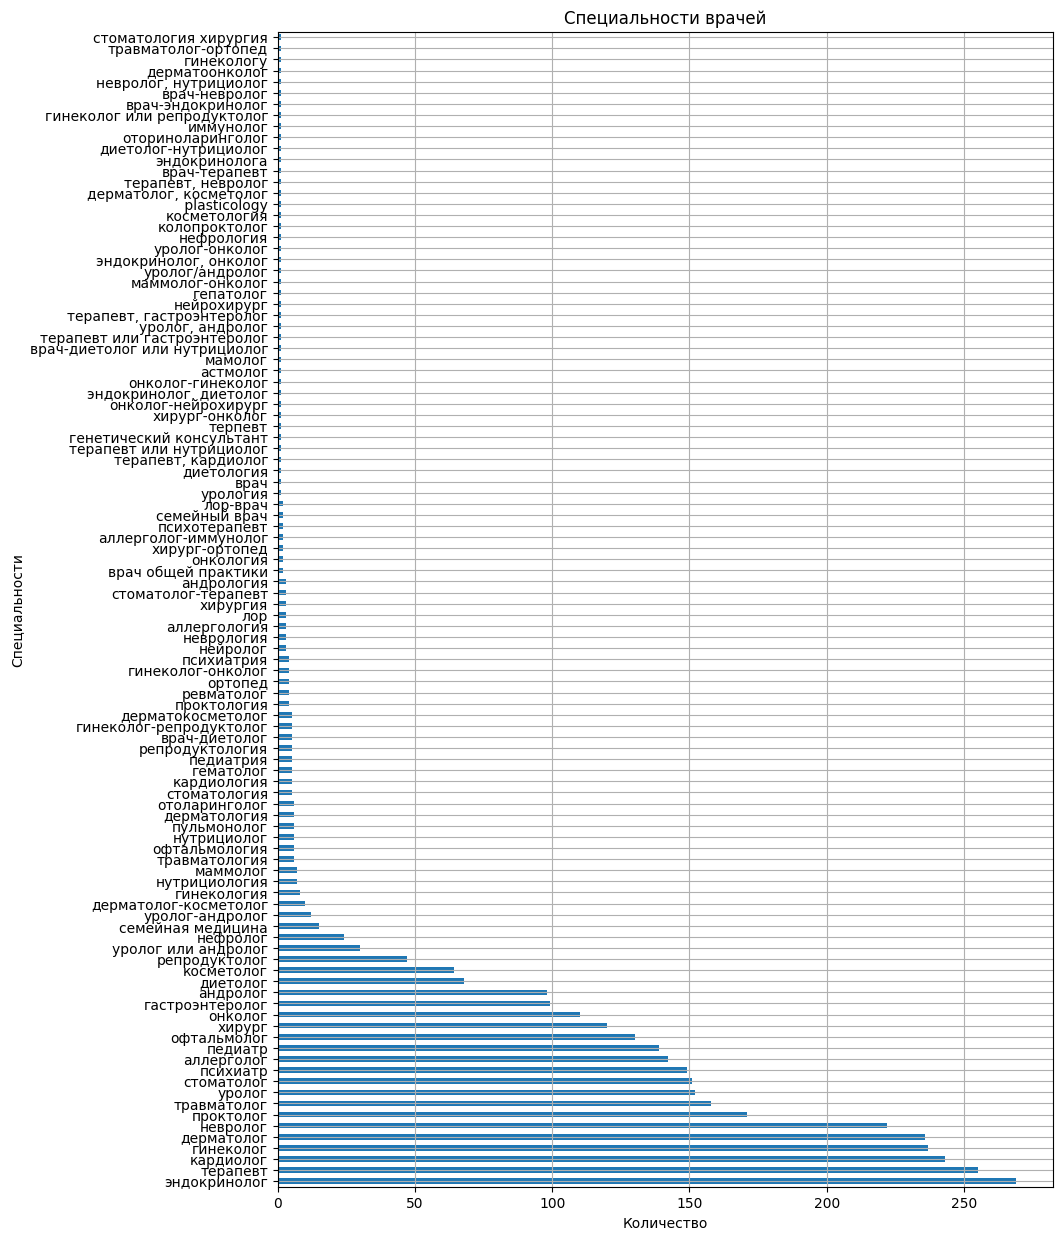

In [265]:
# Сравним, какие специальности докторов представлены в датасете и в каком кол-ве
plt.figure(figsize=(10, 15))
new_data['to_doctor'].value_counts().plot(kind='barh')
plt.title('Специальности врачей')
plt.xlabel('Количество')
plt.ylabel('Специальности')
plt.grid(True)

В описании к датасету не было ничего сказано, каким образом определялся топик. Его выбирал сам юзер или бот? Создаётся впечатление будто бы топик выбирал сам юзер, а бот, невзирая на топик обращения, определял врача сам и направлял уже к нему. Тогда понятно, почему такая разница между топиками и специальностями. И тогда имеет смысл ориентироваться на специальности врачей, а не на топики обращений.

Оставим специальности, к которым обращаются больше всего. А более узкопрофильные специальности, на основании наиболее популярных жалоб юзеров в данной группе и на основании принадлежности к более "популярной" специальности (как например: уролог-андролог, сочетает в себе и уролога, и андролога) сгруппируем с другими.

* *Колопроктолога* можно объединить с *хирургом*;
* *Травмотолога* тоже можно объединить с *хирургом*;
* Учитывая какие жалобы были у пациентов направленных к *аллергологу*, их можно сгруппировать с *терапевтом*;
* *Гастроэнтеролога* тоже можно отнести к *терапевту* и т.д.

In [266]:
# new_data['to_doctor'].unique()

In [267]:
# Перезапишем значения, чтобы сократить кол-во уникальных значений
# Создадим функцию, которая будет проверять значение и перезаписывать его
def new_name(value: object) -> str:
    """Функция для замены значений в столбце 'to_doctor'
    
    Args: 
        значения типа object

    Returns:
       значения типа str
    """
    
    if value in ['эндокринолог', 
                 'эндокринолог, диетолог', 
                 'эндокринолога',
                 'эндокринолог, онколог',
                 'врач-эндокринолог']:
        return 'эндокринолог'
    
    elif value in ['терапевт', 
                   'семейная медицина', 
                   'нутрициология',
                   'нутрициолог',
                   'пульмонолог',
                   'гематолог',
                   'врач общей практики',
                   'семейный врач',
                   'врач-терапевт',
                   'врач',
                   'терапевт или нутрициолог',
                   'терпевт',
                   'аллерголог',
                   'аллергология',
                   'аллерголог-иммунолог',
                   'иммунолог',
                   'астмолог',
                   'гастроэнтеролог',
                   'диетолог',
                   'врач-диетолог',
                   'диетология',
                   'диетолог-нутрициолог',
                   'врач диетолог или нутрициолог',
                   'терапевт или гастроэнтеролог',
                   'терапевт, гастроэнтеролог',
                   'врач-диетолог или нутрициолог',
                   'гепатолог',
                   'оториноларинголог', 
                   'отоларинголог', 
                   'лор',
                   'лор-врач',
                   'терапевт, нутрициолог',
                   'генетик',
                   'терапевт/нутрициолог',
                   'инфекционист',
                   'флеболог']:
        return 'терапевт'
    
    elif value in ['кардиолог', 
                   'кардиология',
                   'терапевт-кардиолог',
                   'терапевт, кардиолог']:
        return 'кардиолог'
    
    elif value in ['гинеколог', 
                   'репродуктолог',
                   'гинекология',
                   'гинеколог-репродуктолог',
                   'репродуктология',
                   'гинеколог-онколог',
                   'гинеколог или репродуктолог',
                   'гинекологу',
                   'онколог-гинеколог',
                   'гинеколог-эндокринолог']:
        return 'гинеколог'
    
    elif value in ['дерматолог', 
                   'косметолог',
                   'дерматолог-косметолог',
                   'дерматология',
                   'дерматокосметолог',
                   'косметология',
                   'дерматолог, косметолог',
                   ' plasticology',
                   'дерматоонколог',
                   'дерматолог-аллерголог']:
        return 'дерматолог'
    
    elif value in ['невролог', 
                   'нейролог',
                   'неврология',
                   'терапевт, невролог',
                   'врач-невролог',
                   'невролог, нутрициолог']:
        return 'невролог'
    
    elif value in ['хирург', 
                   'хирургия', 
                   'нейрохирург',
                   'проктолог',
                   'проктология',
                   'колопроктолог',
                   'травматолог',
                   'травматология',
                   'ортопед',
                   'ревматолог',
                   'хирург-ортопед',
                   'травматолог-ортопед',
                   'ортопед-травматолог']:
        return 'хирург'
    
    elif value in ['уролог', 
                   'андролог',
                   'уролог или андролог',
                   'нефролог',
                   'уролог-андролог',
                   'андрология',
                   'нефрология',
                   'уролог-онколог',
                   'уролог/андролог',
                   'урология',
                   'уролог, андролог',
                   'врач-уролог']:
        return 'уролог'
    
    elif value in ['стоматолог', 
                   'стоматология',
                   'стоматолог-терапевт',
                   'стоматология хирургия',
                   'стоматолог-хирург']:
        return 'стоматолог'
    
    elif value in ['психиатр', 
                   'психиатрия',
                   'психотерапевт']:
        return 'психиатр'
    
    elif value in ['педиатр',
                   'педиатрия']:
        return 'педиатр'
    
    elif value in ['офтальмолог',
                   'офтальмология',
                   'офтальмологу']:
        return 'офтальмолог'
    
    elif value in ['онколог', 
                   'маммолог', 
                   'онкология', 
                   'хирург-онколог',
                   'генетический консультант',
                   'онколог-нейрохирург',
                   'маммолог-онколог',
                   'мамолог']:
        return 'онколог'

    else:
        return value

In [ ]:
# Альтернатива функции №1
# new_data[new_data["to_doctor"].str.contains("эндо")]

# Альтернатива функции №2
# from difflib import get_close_matches

In [268]:
# Применим эту функцию
new_data['to_doctor'] = new_data['to_doctor'].apply(new_name)

In [269]:
# Посмотрим, что получилось 
new_data['to_doctor'].value_counts(dropna=False)

to_doctor
терапевт        641
хирург          475
дерматолог      325
уролог          324
гинеколог       309
эндокринолог    273
кардиолог       249
невролог        231
стоматолог      160
психиатр        155
педиатр         144
офтальмолог     136
онколог         124
Name: count, dtype: int64

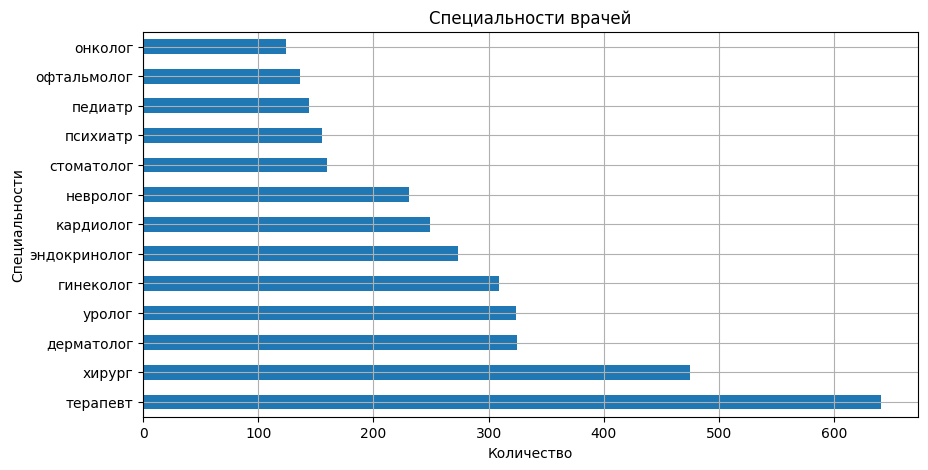

In [270]:
plt.figure(figsize=(10, 5))
new_data['to_doctor'].value_counts().plot(kind='barh')
plt.title('Специальности врачей')
plt.xlabel('Количество')
plt.ylabel('Специальности')
plt.grid(True)

In [271]:
# Оставим необходимые нам признаки
train_data = new_data[['user_question', 'to_doctor']]
train_data

,user_question,to_doctor
0,Я сдала анализ крови на сахар и показатели чут...,эндокринолог
1,"Мой ребенок кашляет уже 3 дня, отхаркивается с...",педиатр
2,Я заметил не очень приятного вида опухоль возл...,хирург
3,У меня повышенный уровень сахара в крови. Врач...,эндокринолог
4,У меня постоянно болит голова. Я уже несколько...,невролог
...,...,...
3541,вопрос user по его конкретной медицинской проб...,терапевт
3542,"У меня ушиб локтя, очень болит и опух. Что дел...",хирург
3543,"У меня болит живот, врач предположил, что это ...",хирург
3544,"Я чувствую постоянную тревогу и усталость, даж...",психиатр


In [272]:
# Функция для предобработки `user_question`
def preprocessing_text(text):
    """Функция для предобработки обращения пользователя"""
    
    text = re.sub(r'[^\w\s]', '', text) # Удаляем спецсимволы
    text = re.sub(r'\d+', '', text)     # Удаляем числа
    return text.lower()                 # Приводим к нижнему регистру

In [273]:
# Пременим эту функцию
train_data['user_question'] = train_data['user_question'].apply(preprocessing_text)
train_data

,user_question,to_doctor
0,я сдала анализ крови на сахар и показатели чут...,эндокринолог
1,мой ребенок кашляет уже дня отхаркивается с т...,педиатр
2,я заметил не очень приятного вида опухоль возл...,хирург
3,у меня повышенный уровень сахара в крови врач ...,эндокринолог
4,у меня постоянно болит голова я уже несколько ...,невролог
...,...,...
3541,вопрос user по его конкретной медицинской проб...,терапевт
3542,у меня ушиб локтя очень болит и опух что делать,хирург
3543,у меня болит живот врач предположил что это ап...,хирург
3544,я чувствую постоянную тревогу и усталость даже...,психиатр


In [274]:
# Проверяем на дубликаты
train_data.duplicated().sum()

257

In [ ]:
# # Избавимся от дубликатов
# train_data = train_data.drop_duplicates([subset='user_questiot'])
# train_data.shape

In [275]:
# Избавимся от дубликатов
train_data = train_data.drop_duplicates()
train_data.shape

(3289, 2)

In [276]:
# Изменим индексы на новые
train_data.reset_index(drop=True, inplace=True)

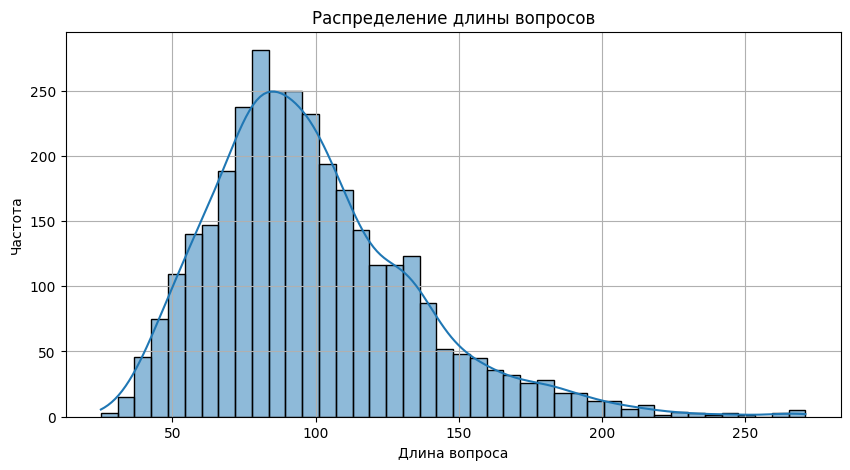

In [277]:
# Распределение длины текста в `user_question`
train_data['question_length'] = train_data['user_question'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(train_data['question_length'], kde=True)
plt.title('Распределение длины вопросов')
plt.xlabel('Длина вопроса')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

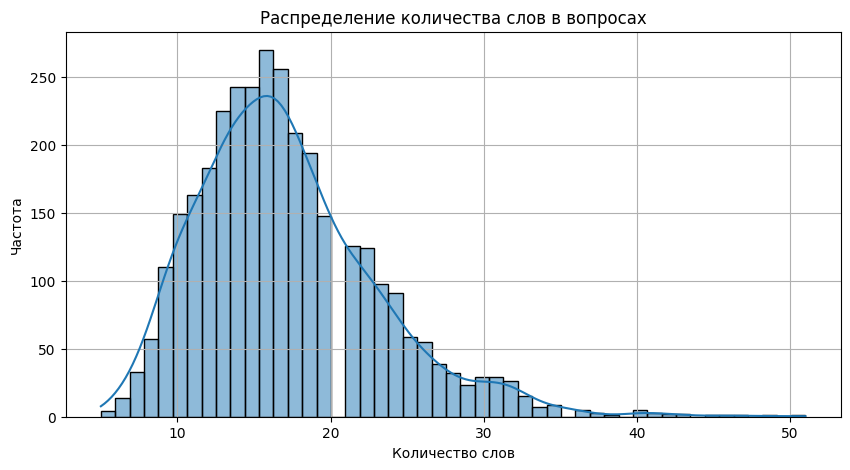

In [278]:
# Распределение кол-ва слов в `user_question`
train_data['word_count'] = train_data['user_question'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(train_data['word_count'], kde=True)
plt.title('Распределение количества слов в вопросах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**<u>Выводы на основе анализа представленных данных:</u>**

1) Распределение правосторонее ("хвост" справа).
2) Преимущетсвенное большинство содержит от 10 до 20 слов (наибольшая частота у вопросов с длиной слов, примерно, 16-17 штук).
3) Вопросы с длиной слов меньше 8 и больше 23 встречаются редко.
4) Очень длинные и очень короткие вопросы могут потребовать отдельной обработки, так как они встречаются реже.

Теперь попробуем проанализировать наиболее часто встречающиеся слова.

In [279]:
# Токенизация слов
all_words = ' '.join(train_data['user_question']).lower()
all_words_tokens = word_tokenize(all_words)

# Удаление стоп-слов
stopwords = set(nltk.corpus.stopwords.words('russian'))

# Список с кастомными стоп-словами, отсутствующими в `stopwords`
custom_stopwords = {"это", "делать", "постоянно", "могу", "особенно"}

# Объединяем стандартные и кастомные стоп-слова в один набор
all_stopwords = stopwords.union(custom_stopwords)
filtered_tokens = [word for word in all_words_tokens if word.isalpha() and word not in all_stopwords]

# Подсчет частотных слов
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(20)

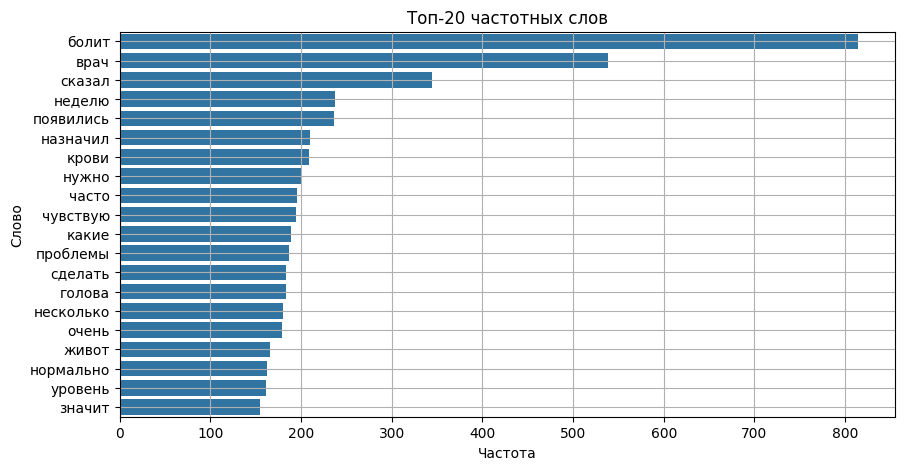

In [280]:
# График частотных слов
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words))
plt.title('Топ-20 частотных слов')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.grid(True)
plt.show()

In [281]:
# Частотные биграммы
bigrams = Counter(ngrams(filtered_tokens, 2)).most_common(10)

# Частотные триграммы
trigrams = Counter(ngrams(filtered_tokens, 3)).most_common(10)

# Отображение
print("Топ-10 биграмм:")
print('-' * 32)
for bigram, freq in bigrams:
    print(f"{' '.join(bigram)}: {freq}")
    
print("\nТоп-10 триграмм:")
print('-' * 32)
for trigram, freq in trigrams:
    print(f"{' '.join(trigram)}: {freq}")

Топ-10 биграмм:
--------------------------------
врач сказал: 279
врач назначил: 184
болит голова: 158
болит живот: 158
болит зуб: 120
несколько дней: 107
повышенный уровень: 83
проблемы пищеварением: 76
появилась сыпь: 72
какому врачу: 70

Топ-10 триграмм:
--------------------------------
врач сказал нужно: 53
болит голова неделю: 49
болит живот внизу: 45
врач сказал связано: 44
проблемы пищеварением часто: 43
чешется кожа руках: 41
кожа руках ногах: 40
уровень сахара крови: 39
уровень холестерина врач: 39
ребенок кашляет неделю: 38


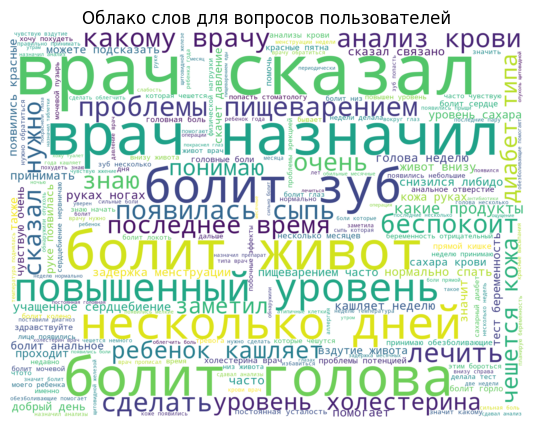

In [282]:
# Облако слов
wordcloud = WordCloud(width=2000, height=1500, background_color='white').generate(' '.join(filtered_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для вопросов пользователей')
plt.show()


In [283]:
# Применим токенизацию к предобработанным вопросам
def text_tokens(text, stopwords):
    """Функция для токенизации предобработанного текста"""
    
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stopwords]

train_data['user_question_tokens'] = train_data['user_question'].apply(lambda x: text_tokens(x, all_stopwords))

In [284]:
# Добавляем индексы к специальностям врачей
doctor_index = {profession: idx for idx, profession in enumerate(sorted(train_data['to_doctor'].unique()))}
train_data['index'] = train_data['to_doctor'].map(doctor_index)

In [285]:
# Изменим порядок вывода столбцов для удобства
train_data = train_data[['index', 'to_doctor', 'user_question', 'question_length', 'word_count', 'user_question_tokens']]
train_data

,index,to_doctor,user_question,question_length,word_count,user_question_tokens
0,12,эндокринолог,я сдала анализ крови на сахар и показатели чут...,141,23,"[сдала, анализ, крови, сахар, показатели, повы..."
1,6,педиатр,мой ребенок кашляет уже дня отхаркивается с т...,74,12,"[ребенок, кашляет, дня, отхаркивается, трудом,..."
2,11,хирург,я заметил не очень приятного вида опухоль возл...,108,18,"[заметил, очень, приятного, вида, опухоль, воз..."
3,12,эндокринолог,у меня повышенный уровень сахара в крови врач ...,132,23,"[повышенный, уровень, сахара, крови, врач, ска..."
4,3,невролог,у меня постоянно болит голова я уже несколько ...,111,18,"[болит, голова, несколько, дней, принимаю, обе..."
...,...,...,...,...,...,...
3284,5,офтальмолог,у меня болит глаз и периодически мерцает перед...,73,13,"[болит, глаз, периодически, мерцает, глазами]"
3285,11,хирург,у меня ушиб локтя очень болит и опух что делать,47,10,"[ушиб, локтя, очень, болит, опух]"
3286,11,хирург,у меня болит живот врач предположил что это ап...,168,25,"[болит, живот, врач, предположил, аппендицит, ..."
3287,7,психиатр,я чувствую постоянную тревогу и усталость даже...,110,19,"[чувствую, постоянную, тревогу, усталость, про..."


Для того, чтобы оценивать работу моделей, предобработаем тестовую выборку.

In [286]:
# Загрузим тестовую выборку
test_data = pd.read_parquet('data/test.parquet')

# Применим нашу ранее написанную функцию, для справления столбца `to_doctor`
test_data['to_doctor'] = test_data['to_doctor'].apply(new_name)

# Пременим функцию для предобработки вопросов пользователей
test_data['user_question'] = test_data['user_question'].apply(preprocessing_text)

# Оставим необходимые нам признаки
test_data = test_data[['user_question', 'to_doctor']]

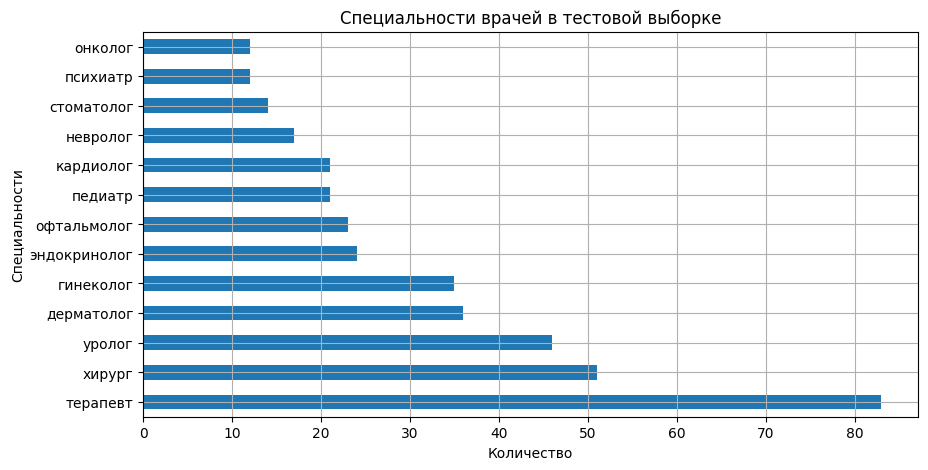

In [287]:
plt.figure(figsize=(10, 5))
test_data['to_doctor'].value_counts().plot(kind='barh')
plt.title('Специальности врачей в тестовой выборке')
plt.xlabel('Количество')
plt.ylabel('Специальности')
plt.grid(True)

In [288]:
# Проверяем на дубликаты тестовую выборку
test_data.duplicated().sum()

4

In [289]:
# Избавимся от дубликатов
test_data = test_data.drop_duplicates()

# Изменим индексы на новые
test_data.reset_index(drop=True, inplace=True)

test_data.shape

(391, 2)

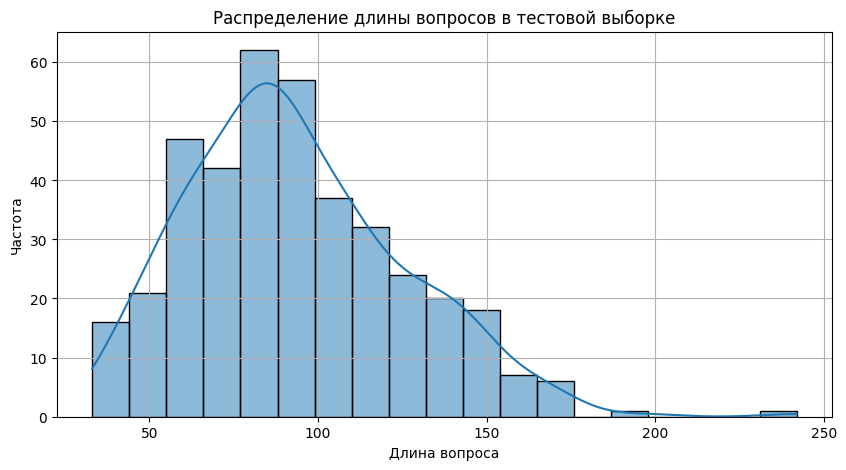

In [290]:
# Распределение длины текста `user_question` в тестовой выборке
test_data['question_length'] = test_data['user_question'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(test_data['question_length'], kde=True)
plt.title('Распределение длины вопросов в тестовой выборке')
plt.xlabel('Длина вопроса')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

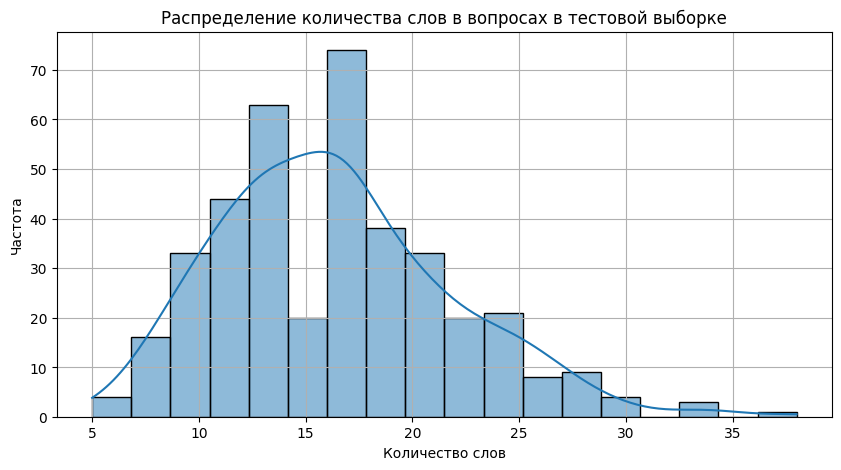

In [291]:
# Распределение кол-ва слов `user_question` в тестовой выборке
test_data['word_count'] = test_data['user_question'].str.split().str.len()

plt.figure(figsize=(10, 5))
sns.histplot(test_data['word_count'], kde=True)
plt.title('Распределение количества слов в вопросах в тестовой выборке')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [292]:
# Токенизация слов
test_all_words = ' '.join(test_data['user_question']).lower()
test_all_words_tokens = word_tokenize(test_all_words)

test_filtered_tokens = [word for word in test_all_words_tokens if word.isalpha() and word not in all_stopwords]

# Подсчет частотных слов
test_word_freq = Counter(test_filtered_tokens)
test_common_words = test_word_freq.most_common(20)

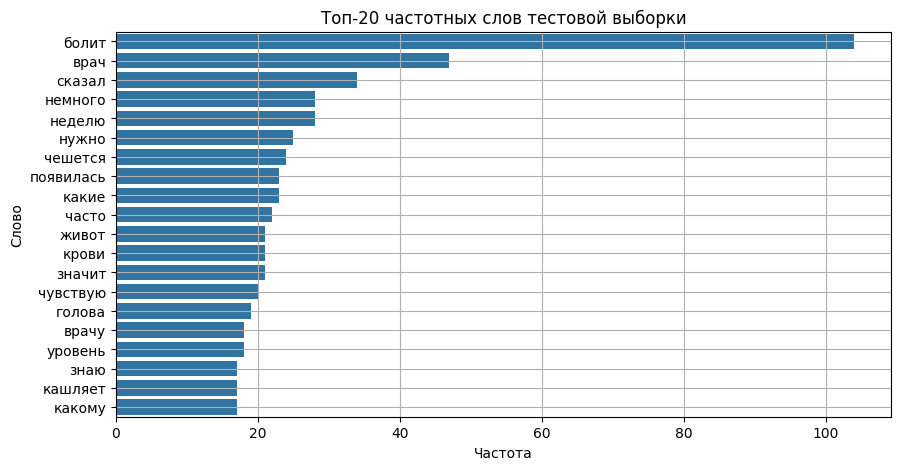

In [293]:
# График частотных слов в тестовой выборке
words, counts = zip(*test_common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words))
plt.title('Топ-20 частотных слов тестовой выборки')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.grid(True)
plt.show()

In [294]:
# Частотные биграммы
test_bigrams = Counter(ngrams(test_filtered_tokens, 2)).most_common(10)

# Частотные триграммы
test_trigrams = Counter(ngrams(test_filtered_tokens, 3)).most_common(10)

# Отображение
print("Топ-10 биграмм в тестовой выборке:")
print('-' * 32)
for bigram, freq in test_bigrams:
    print(f"{' '.join(bigram)}: {freq}")
    
print("\nТоп-10 триграмм в тестовой выборке:")
print('-' * 32)
for trigram, freq in test_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

Топ-10 биграмм в тестовой выборке:
--------------------------------
врач сказал: 26
болит живот: 20
болит голова: 18
какому врачу: 15
болит анальное: 13
тест беременность: 13
руке появилась: 12
появилась сыпь: 12
болит зуб: 12
врач назначил: 12

Топ-10 триграмм в тестовой выборке:
--------------------------------
болит анальное отверстие: 11
тест беременность отрицательный: 11
значит какому врачу: 9
руке появилась сыпь: 7
ребенок кашляет неделю: 7
болит голова неделю: 7
кожа руках ногах: 6
какому врачу нужно: 6
врачу нужно обратиться: 6
сыпь которая чешется: 5


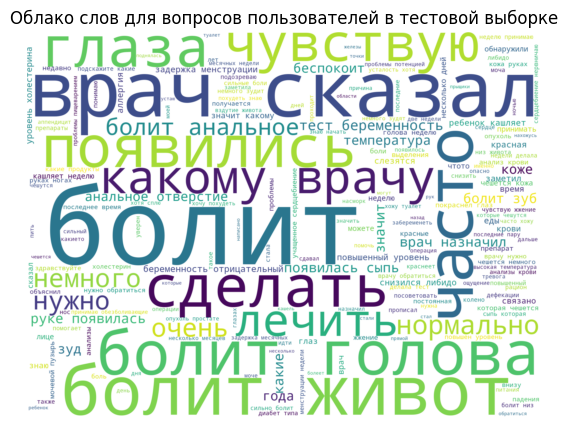

In [295]:
# Облако слов
test_wordcloud = WordCloud(width=2000, height=1500, background_color='white').generate(' '.join(test_filtered_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(test_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для вопросов пользователей в тестовой выборке')
plt.show()

In [296]:
# Применим токенизацию к предобработанным вопросам
test_data['user_question_tokens'] = test_data['user_question'].apply(lambda x: text_tokens(x, all_stopwords))

# Добавляем индексы к специальностям врачей
test_data['index'] = test_data['to_doctor'].map(doctor_index)

In [297]:
# Итоговый вид предобработанной тестовой выборки
test_data = test_data[['index', 'to_doctor', 'user_question', 'question_length', 'word_count', 'user_question_tokens']]
test_data

,index,to_doctor,user_question,question_length,word_count,user_question_tokens
0,1,дерматолог,у меня на руке появилась сыпь которая чешется ...,83,15,"[руке, появилась, сыпь, которая, чешется, немн..."
1,11,хирург,у меня на ноге сильный отек после растяжения ...,79,14,"[ноге, сильный, отек, растяжения, быстрее, сошел]"
2,9,терапевт,я хочу похудеть но не знаю с чего начать может...,66,12,"[хочу, похудеть, знаю, начать, можете, посовет..."
3,10,уролог,у меня болит живот и у меня проблемы с потенци...,68,14,"[болит, живот, проблемы, потенцией]"
4,5,офтальмолог,у меня покраснел белок глаза и немного болит ч...,63,12,"[покраснел, белок, глаза, немного, болит]"
...,...,...,...,...,...,...
386,0,гинеколог,у меня очень сильные боли во время месячных чт...,54,10,"[очень, сильные, боли, время, месячных]"
387,4,онколог,у меня обнаружили опухоль в легких доктор сказ...,120,20,"[обнаружили, опухоль, легких, доктор, сказал, ..."
388,10,уролог,у меня постоянно болит низ живота справа в ту...,143,25,"[болит, низ, живота, справа, туалет, хожу, час..."
389,0,гинеколог,у меня задержка менструации уже две недели я с...,105,17,"[задержка, менструации, две, недели, сдавала, ..."


## <center>2. Моделирование и оценка модели</center>

In [298]:
# Обучение модели Word2Vec
tokens_list = train_data['user_question_tokens'].tolist()
w2v_model = Word2Vec(sentences=tokens_list, vector_size=100, window=5, min_count=1, sg=1)

In [299]:
# Построение эмбеддингов текстов (среднее по словам)
def get_text_embedding(tokens, model):
    """Функция для построения эмбеддингов токенизированного текста"""
    
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

train_data['text_embedding'] = train_data['user_question_tokens'].apply(lambda x: get_text_embedding(x, w2v_model))
test_data['text_embedding'] = test_data['user_question_tokens'].apply(lambda x: get_text_embedding(x, w2v_model))


In [300]:
# Подготовка данных для обучения
X_train = np.vstack(train_data['text_embedding'].values)
y_train = train_data['index']  

X_test = np.vstack(test_data['text_embedding'].values)
y_test = test_data['index'] 

In [301]:
# Настройка гиперпараметров моделей
model_params = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'multi_class': ['auto', 'ovr', 'multinomial']
        }
    },
    
    'Decision_Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [4, 5, 6, 7, 8, 9, 10], 
            'min_samples_split': [3, 4, 5, 10] 
        }
    },
    
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'max_features': ['sqrt', 'log2'],
            'max_depth': [4, 5, 6, 7, 8],
            'criterion': ['gini', 'entropy']
        }
    }
}

In [302]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [303]:
# Сохраняем результаты
best_results = pd.DataFrame(scores, columns=['model','best_score','best_params'])
best_results

,model,best_score,best_params
0,Logistic_Regression,0.578894,"{'multi_class': 'auto', 'penalty': 'l1', 'solv..."
1,Decision_Tree,0.569462,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
2,Random_Forest,0.661896,"{'criterion': 'entropy', 'max_depth': 8, 'max_..."


*Random Forest* явный лидер, ожидаемо.

In [315]:
# Выбираем наилучшие параметры для случайного леса
best_results.best_params[2]

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}

In [316]:
# Создаём модель
rf_model = RandomForestClassifier(criterion = 'entropy',
                               max_depth = 8, 
                               max_features = 'sqrt')
rf_model.fit(X_train, y_train)
rf_y_predict = rf_model.predict(X_test)

In [317]:
# Оценка нашей модели
print('\n-- Random Forest --')
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, rf_y_predict))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, rf_y_predict))
print('')


-- Random Forest --
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.88      0.81      0.84        36
           2       0.86      0.60      0.71        20
           3       0.56      0.53      0.55        17
           4       0.47      0.58      0.52        12
           5       0.89      0.73      0.80        22
           6       1.00      0.76      0.86        21
           7       0.75      0.50      0.60        12
           8       1.00      0.64      0.78        14
           9       0.69      0.66      0.67        83
          10       0.71      0.74      0.72        46
          11       0.53      0.84      0.65        49
          12       0.54      0.54      0.54        24

    accuracy                           0.71       391
   macro avg       0.76      0.68      0.71       391
weighted avg       0.74      0.71      0.72       391

Confusion Matrix:
[[32  0  0  0  1 

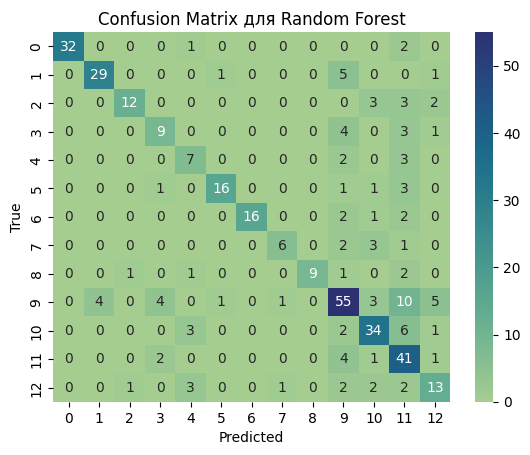

In [321]:
# Построим confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_y_predict), annot = True, cmap="crest")
plt.title('Confusion Matrix для Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [326]:
# Загрузка токенайзера и модели RuBERT
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [327]:
# Функция для получения эмбеддинга текста №2 (теперь можно добавить токенизатор и модель)
def get_text_embedding_2(text, tokenizer, model, max_length=128):
    """Функция для построения эмбеддингов токенизированного текста №2"""
    
    inputs = tokenizer(
        text, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy() # Возьмем эмбеддинги CLS-токена (первая позиция [CLS])
    return cls_embedding

In [328]:
# Преобразуем токены в текст
train_data['text'] = train_data['user_question_tokens'].apply(lambda x: " ".join(x))  
test_data['text'] = test_data['user_question_tokens'].apply(lambda x: " ".join(x))  

In [329]:
# Получение эмбеддингов для всех строк
train_data['cls_embedding'] = train_data['text'].apply(lambda x: get_text_embedding_2(x, tokenizer, model))
test_data['cls_embedding'] = test_data['text'].apply(lambda x: get_text_embedding_2(x, tokenizer, model))

In [ ]:
# Подготовка данных для обучения
X_train_2 = np.vstack(train_data['cls_embedding'].values)
X_test_2 = np.vstack(test_data['cls_embedding'].values)

In [331]:
# Подбираем параметры
scores_2 = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False)
    clf.fit(X_train_2, y_train)
    scores_2.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [332]:
# Сохраняем результаты
best_results_2 = pd.DataFrame(scores_2, columns=['model','best_score','best_params'])
best_results_2

,model,best_score,best_params
0,Logistic_Regression,0.746725,"{'multi_class': 'ovr', 'penalty': 'l2', 'solve..."
1,Decision_Tree,0.344780,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
2,Random_Forest,0.536626,"{'criterion': 'entropy', 'max_depth': 8, 'max_..."


В случае текстов, обработанных RuBERT, лучше всего себя показала *Logistic Regression*.

In [333]:
# Выбираем наилучшие параметры для логистической регрессии
best_results_2.best_params[0]

{'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}

In [334]:
# Создаём модель
lg_model = LogisticRegression(solver = 'newton-cg',
                              penalty = 'l2',
                              multi_class = 'ovr',
                              random_state = 42)
lg_model.fit(X_train_2, y_train)
lg_y_predict = lg_model.predict(X_test_2)

In [335]:
# Оценка нашей модели
print('\n-- Logistic Regression --')
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, lg_y_predict))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, lg_y_predict))
print('')


-- Logistic Regression --
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.80      0.78      0.79        36
           2       0.78      0.70      0.74        20
           3       0.57      0.71      0.63        17
           4       0.64      0.58      0.61        12
           5       0.83      0.86      0.84        22
           6       1.00      1.00      1.00        21
           7       0.83      0.83      0.83        12
           8       1.00      0.86      0.92        14
           9       0.66      0.70      0.68        83
          10       0.81      0.85      0.83        46
          11       0.73      0.82      0.77        49
          12       0.73      0.46      0.56        24

    accuracy                           0.77       391
   macro avg       0.80      0.77      0.78       391
weighted avg       0.78      0.77      0.77       391

Confusion Matrix:
[[31  0  0 

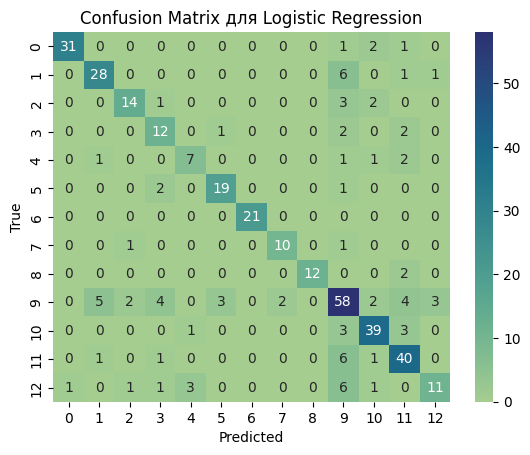

In [337]:
# Построим confusion matrix
sns.heatmap(confusion_matrix(y_test, lg_y_predict), annot = True, cmap="crest")
plt.title('Confusion Matrix для Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()